<a href="https://colab.research.google.com/github/ricoprediansyah/CV-FASTER_RCNN_RESNET_COUNT_PALM_TREES_FULL_PROGRAM/blob/main/FASTER_RCNN_RESNET34_COUNT_PALM_TREES_MAPPING_FULL_PROGRAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##DATASET

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="PZMfN1gExhcqfGkkkd43")
project = rf.workspace("cryospace-yylkk").project("palm-tree-label-200m-splitted")
version = project.version(4)
dataset = version.download("voc")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Palm-Tree-Label-200m-Splitted-4 in voc:: 100%|██████████| 869/869 [00:01<00:00, 602.31it/s]


In [ ]:
# Membuat folder images dan annotations
!mkdir -p images annotations

In [ ]:
import os
import shutil

# Daftar folder sumber
folders = ['/content/Palm-Tree-Label-200m-Splitted-4/test', '/content/Palm-Tree-Label-200m-Splitted-4/train', '/content/Palm-Tree-Label-200m-Splitted-4/valid']

# Membuat folder tujuan jika belum ada
os.makedirs('/content/images', exist_ok=True)
os.makedirs('/content/annotations', exist_ok=True)

# Memindahkan file berdasarkan ekstensi
for folder in folders:
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)

        # Memindahkan file .xml ke /content/annotations
        if filename.endswith('.xml'):
            shutil.move(file_path, '/content/annotations/')

        # Memindahkan file .png, .jpg, atau .jpeg ke /content/images
        elif filename.endswith(('.png', '.jpg', '.jpeg')):
            shutil.move(file_path, '/content/images/')

In [ ]:
import os
import random
import numpy as np
import shutil

# Menghitung dan mencetak jumlah file di folder annotations dan images
print(f'Jumlah file di annotations: {len(os.listdir("annotations"))}')
print(f'Jumlah file di images: {len(os.listdir("images"))}')

# Membuat folder test_images dan test_annotations
os.makedirs('test_images', exist_ok=True)
os.makedirs('test_annotations', exist_ok=True)

# Mengatur seed untuk reproducibility
random.seed(1234)

# Menghitung jumlah dataset
total_data = 432
test_data_count = int(0.15 * total_data)  # 15% dari total_data

# Mengambil indeks secara acak untuk 15% data
idx = random.sample(range(total_data), test_data_count)

# Memindahkan file gambar ke test_images
for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move(os.path.join('images', img), os.path.join('test_images', img))

# Memindahkan file anotasi ke test_annotations
for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move(os.path.join('annotations', annot), os.path.join('test_annotations', annot))

# Menghitung dan mencetak jumlah file setelah pemindahan
print(f'Jumlah file di annotations setelah pemindahan: {len(os.listdir("annotations"))}')
print(f'Jumlah file di images setelah pemindahan: {len(os.listdir("images"))}')
print(f'Jumlah file di test_annotations: {len(os.listdir("test_annotations"))}')
print(f'Jumlah file di test_images: {len(os.listdir("test_images"))}')

Jumlah file di annotations: 432
Jumlah file di images: 432
Jumlah file di annotations setelah pemindahan: 368
Jumlah file di images setelah pemindahan: 368
Jumlah file di test_annotations: 64
Jumlah file di test_images: 64


In [ ]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import time

In [ ]:
def generate_box(obj):
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

In [ ]:
adjust_label = 0

def generate_label(obj):
    # Mengembalikan label 1 untuk class "Palm-Trees"
    if obj.find('name').text == "Palm-Tree":
        return 1 + adjust_label

    # Jika class tidak dikenali, kembalikan 0
    return 0 + adjust_label

In [ ]:
def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

In [ ]:
def plot_image_from_output(img, annotation):

    img = img.cpu().permute(1,2,0)

    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        else :

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # define the path to the images and what transform will be used
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
data_transform = transforms.Compose([  # transforms.Compose : a class that calls the functions in a list consecutively
        transforms.ToTensor() # ToTensor : convert numpy image to torch.Tensor type
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, 'images/')
test_dataset = MaskDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

##LOAD MODEL AND TRAINING

In [ ]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

def get_model_instance_segmentation(num_classes, max_detections=1000):
    # Load ResNet34 backbone with FPN
    backbone = resnet_fpn_backbone('resnet34', pretrained=True)

    # Create Faster R-CNN model using the custom backbone
    model = FasterRCNN(backbone, num_classes=num_classes)

    # Set the maximum number of detections per image
    model.roi_heads.detections_per_img = max_detections

    return model

In [ ]:
# Instansiasi model dengan 2 kelas (Palm Tree + Background) dan set max 1000 deteksi per gambar
model = get_model_instance_segmentation(2, max_detections=1000)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 148MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride

In [ ]:
torch.cuda.is_available()

True

In [ ]:
num_epochs = 20
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------
epoch : 1, Loss : 119.02899932861328, time : 87.61817598342896
epoch : 2, Loss : 79.80999755859375, time : 86.4072937965393
epoch : 3, Loss : 67.87725830078125, time : 85.56609106063843
epoch : 4, Loss : 63.016483306884766, time : 85.73126459121704
epoch : 5, Loss : 61.74053192138672, time : 86.05692315101624
epoch : 6, Loss : 60.18421173095703, time : 86.58923745155334
epoch : 7, Loss : 58.625545501708984, time : 85.52882194519043
epoch : 8, Loss : 57.021080017089844, time : 86.34557867050171
epoch : 9, Loss : 56.09943389892578, time : 85.73232650756836
epoch : 10, Loss : 54.56134796142578, time : 86.06797623634338
epoch : 11, Loss : 53.21010971069336, time : 85.02630090713501
epoch : 12, Loss : 52.117488861083984, time : 85.10060596466064
epoch : 13, Loss : 51.4411735534668, time : 86.88392901420593
epoch : 14, Loss : 50.651939392089844, time : 86.30244207382202
epoch : 15, Loss : 50.440277099609375, time : 86.08875179290771

In [ ]:
torch.save(model.state_dict(),f'model_{num_epochs}.pt')

In [ ]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


<All keys matched successfully>

##TEST AND EVALUATION

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold :
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:
with torch.no_grad():
    # batch size of the test set = 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[8.2287e+02, 6.0882e+02, 9.8160e+02, 7.7417e+02],
        [1.4116e+01, 7.2232e+02, 1.5531e+02, 8.9070e+02],
        [1.2548e+03, 9.5100e+02, 1.3948e+03, 1.1191e+03],
        [1.1131e+03, 6.1194e+02, 1.2562e+03, 7.5449e+02],
        [4.0993e+02, 1.2003e+03, 5.6317e+02, 1.3700e+03],
        [1.5814e+03, 4.1481e+02, 1.7304e+03, 5.6701e+02],
        [9.0257e+02, 7.3440e+02, 1.0570e+03, 9.2315e+02],
        [8.6703e+02, 9.9027e+02, 1.0324e+03, 1.1736e+03],
        [2.1615e+02, 1.0751e+03, 3.6094e+02, 1.2304e+03],
        [1.4654e+03, 7.4849e+02, 1.5877e+03, 9.0520e+02],
        [1.3106e+03, 1.1244e+02, 1.4550e+03, 2.4826e+02],
        [1.2570e+03, 6.2598e+02, 1.4101e+03, 7.7638e+02],
        [7.0877e+02, 2.8922e+02, 8.4723e+02, 4.5502e+02],
        [4.0995e+01, 1.2854e+03, 1.8967e+02, 1.4547e+03],
        [1.0193e+03, 1.0403e+03, 1.1749e+03, 1.2070e+03],
        [4.2882e+01, 1.5545e+03, 1.9162e+02, 1.7063e+03],
        [3.6135e+02, 8.5343e+02, 5.1674e+02, 1.0150e+03],
   

Target (Ground Truth):  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


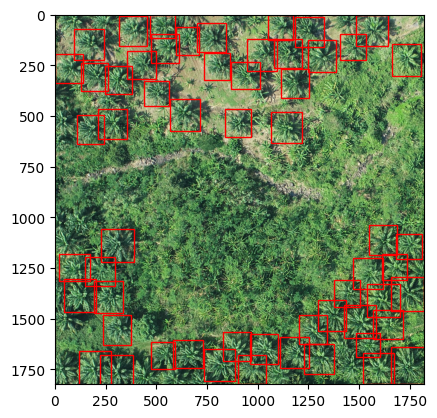

Prediction:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


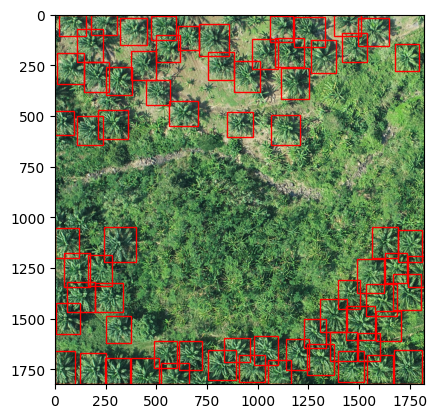

Jumlah label ground truth: 57
Jumlah label hasil prediksi: 59
Accuracy: 96.61%


In [ ]:
# Tentukan threshold untuk confidence score
threshold = 0.91

# GPU index untuk data yang digunakan
_idx = 1

# Pastikan tensor diubah menjadi numpy setelah dipindahkan ke CPU
print("Target (Ground Truth): ", annotations[_idx]['labels'].cpu().numpy())  # Pindahkan labels ke CPU sebelum dicetak

# Pindahkan gambar ke CPU untuk visualisasi
imgs_cpu = imgs[_idx].cpu()

# Pindahkan setiap tensor di dalam annotations (ground truth) ke CPU
annotations_cpu = {k: v.cpu().numpy() for k, v in annotations[_idx].items()}

# Visualisasikan gambar dan anotasi (ground truth)
plot_image_from_output(imgs_cpu, annotations_cpu)

# Pindahkan prediksi ke CPU
pred_cpu = {k: v.cpu().numpy() for k, v in pred[_idx].items()}

# Visualisasikan gambar dan prediksi
print("Prediction: ", pred_cpu['labels'])
plot_image_from_output(imgs_cpu, pred_cpu)

# Hitung label ground truth dan prediksi
ground_truth_labels = annotations[_idx]['labels'].cpu().numpy()
predicted_labels = pred_cpu['labels']

# Filter prediksi berdasarkan threshold
valid_indices = np.where(pred_cpu['scores'] >= threshold)[0]
predicted_labels = predicted_labels[valid_indices]

# Jumlah label asli (ground truth) dan hasil prediksi
print(f"Jumlah label ground truth: {len(ground_truth_labels)}")
print(f"Jumlah label hasil prediksi: {len(predicted_labels)}")

# Menghitung akurasi dengan membagi jumlah label hasil prediksi dengan jumlah label ground truth
accuracy = len(ground_truth_labels) / len(predicted_labels) * 100 if len(ground_truth_labels) > 0 else 0
print(f"Accuracy: {accuracy:.2f}%")


In [ ]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 45 (delta 18), reused 17 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 11.62 KiB | 11.62 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [ ]:
!mv /content/Tutorial-Book-Utils/utils_ObjectDetection.py /content/

In [ ]:
import utils_ObjectDetection as utils

# Menghitung True Positives, pred_scores, dan pred_labels dari batch statistics
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]

# Menghitung Precision, Recall, dan F1 Score
precision, recall, ap, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))

# Menghitung Akurasi
total_detections = true_positives.shape[0]  # Jumlah semua prediksi (TP + FP)
TP_sum = true_positives.sum()  # Jumlah True Positives
accuracy = TP_sum / total_detections  # Akurasi = TP / (TP + FP)

# Output hasil evaluasi
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'Accuracy: {accuracy.item()}')

Precision: tensor([0.9448])
Recall: tensor([0.9690])
F1-score: tensor([0.9568])
Accuracy: 0.9448046684265137


In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.963068670378675
AP : tensor([0.9631], dtype=torch.float64)


In [ ]:
# Hitung True Positives, pred_scores, dan pred_labels dari batch statistics
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]

# Menghitung Precision, Recall, dan F1 Score
precision, recall, ap, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))

# Menghitung Akurasi
total_detections = true_positives.shape[0]  # Jumlah semua prediksi (TP + FP)
TP_sum = true_positives.sum()  # Jumlah True Positives
accuracy = TP_sum / total_detections if total_detections > 0 else 0  # Akurasi = TP / (TP + FP)


# Menghitung Mean Squared Error (MSE) dan Root Mean Squared Error (RMSE)
def calculate_mse_rmse(pred_scores, true_labels):
    """ Menghitung MSE dan RMSE """
    if len(pred_scores) != len(true_labels):
        raise ValueError("Jumlah prediksi dan jumlah label harus sama.")

    # Menghitung MSE
    mse = torch.mean((pred_scores - true_labels) ** 2)
    rmse = torch.sqrt(mse)

    return mse.item(), rmse.item()

# Filter pred_scores dan true_labels untuk memastikan ukurannya sama
valid_indices = true_positives.nonzero(as_tuple=True)[0]  # Ambil indeks True Positives

# Memastikan filtered_pred_scores dan filtered_true_labels memiliki ukuran yang sama
if len(valid_indices) > 0:
    filtered_pred_scores = pred_scores[valid_indices]

    # Ambil true labels yang sesuai dengan pred_labels
    filtered_true_labels = pred_labels[valid_indices]

    # Hitung MSE dan RMSE
    mse, rmse = calculate_mse_rmse(filtered_pred_scores, filtered_true_labels)

    # Output hasil MSE dan RMSE
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
else:
    print("Tidak ada True Positives yang ditemukan.")


Mean Squared Error (MSE): 0.0037797593977302313
Root Mean Squared Error (RMSE): 0.06147974729537964


#PREDIKSI NEW DATA

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


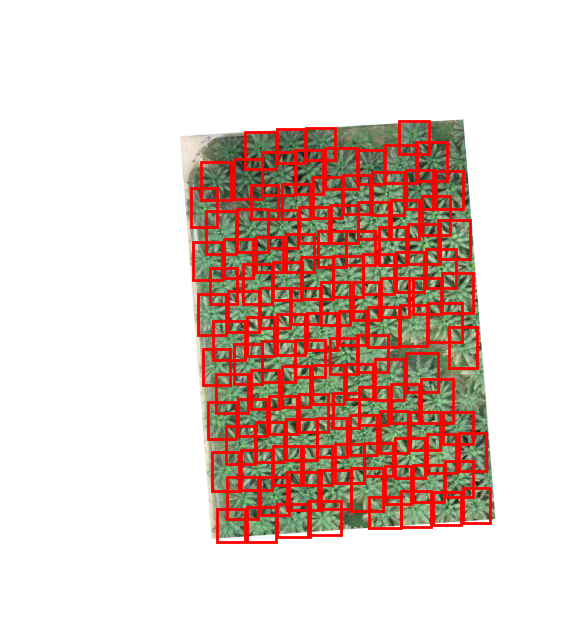

Jumlah objek terdeteksi: 117


In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms

# Fungsi untuk memvisualisasikan gambar dengan kotak prediksi
def plot_image_with_boxes(image, boxes, labels):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)

    ax = plt.gca()
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # Menghilangkan label angka, cukup menampilkan string kosong
        ax.text(xmin, ymin, '', fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# Menaikkan batas maksimal ukuran gambar untuk mencegah DecompressionBombError
Image.MAX_IMAGE_PIXELS = None

# Memuat gambar baru dan mengurangi resolusi jika terlalu besar
img_path = '/content/SAWIT P3 cmprs.jpg'
image = Image.open(img_path).convert("RGB")

# Jika gambar terlalu besar, kurangi ukuran (misalnya 50%)
max_size = (5000, 5000)
if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
    image.thumbnail(max_size, Image.LANCZOS)  # Mengganti ANTIALIAS dengan LANCZOS

# Konversi gambar menjadi tensor
transform = transforms.ToTensor()
image_tensor = transform(image).unsqueeze(0).to(device)  # Mengubah menjadi tensor dan menambah dimensi batch

# Pastikan model sudah dimuat dan berada dalam mode eval
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model_instance_segmentation(2)  # Menggunakan 2 kelas (1 objek + background)
model.load_state_dict(torch.load('model_20.pt'))  # Memuat model yang sudah dilatih
model.to(device)
model.eval()

# Melakukan prediksi
with torch.no_grad():
    pred = model(image_tensor)

# Menentukan threshold untuk prediksi
threshold = 0.01
pred_boxes = []
pred_labels = []

# Menyaring prediksi berdasarkan skor
for idx in range(len(pred)):
    for i, score in enumerate(pred[idx]['scores']):
        if score > threshold:
            pred_boxes.append(pred[idx]['boxes'][i].cpu().numpy())
            pred_labels.append(pred[idx]['labels'][i].cpu().numpy())

# Menampilkan gambar asli dengan kotak prediksi
plot_image_with_boxes(image, pred_boxes, pred_labels)

# Menghitung jumlah box (bounding boxes)
num_boxes = len(pred_boxes)
print(f"Jumlah objek terdeteksi: {num_boxes}")

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


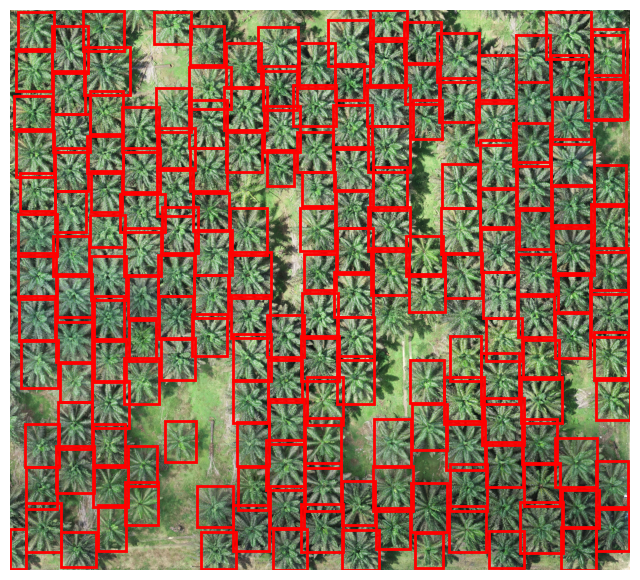

Jumlah objek terdeteksi: 183


In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms

# Fungsi untuk memvisualisasikan gambar dengan kotak prediksi
def plot_image_with_boxes(image, boxes, labels):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)

    ax = plt.gca()
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # Menghilangkan label angka, cukup menampilkan string kosong
        ax.text(xmin, ymin, '', fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# Menaikkan batas maksimal ukuran gambar untuk mencegah DecompressionBombError
Image.MAX_IMAGE_PIXELS = None

# Memuat gambar baru dan mengurangi resolusi jika terlalu besar
img_path = '/content/SAWIT P2 cmprs.jpg'
image = Image.open(img_path).convert("RGB")

# Jika gambar terlalu besar, kurangi ukuran (misalnya 50%)
max_size = (5000, 5000)
if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
    image.thumbnail(max_size, Image.LANCZOS)  # Mengganti ANTIALIAS dengan LANCZOS

# Konversi gambar menjadi tensor
transform = transforms.ToTensor()
image_tensor = transform(image).unsqueeze(0).to(device)  # Mengubah menjadi tensor dan menambah dimensi batch

# Pastikan model sudah dimuat dan berada dalam mode eval
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model_instance_segmentation(2)  # Menggunakan 2 kelas (1 objek + background)
model.load_state_dict(torch.load('model_20.pt'))  # Memuat model yang sudah dilatih
model.to(device)
model.eval()

# Melakukan prediksi
with torch.no_grad():
    pred = model(image_tensor)

# Menentukan threshold untuk prediksi
threshold = 0.01
pred_boxes = []
pred_labels = []

# Menyaring prediksi berdasarkan skor
for idx in range(len(pred)):
    for i, score in enumerate(pred[idx]['scores']):
        if score > threshold:
            pred_boxes.append(pred[idx]['boxes'][i].cpu().numpy())
            pred_labels.append(pred[idx]['labels'][i].cpu().numpy())

# Menampilkan gambar asli dengan kotak prediksi
plot_image_with_boxes(image, pred_boxes, pred_labels)

# Menghitung jumlah box (bounding boxes)
num_boxes = len(pred_boxes)
print(f"Jumlah objek terdeteksi: {num_boxes}")

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


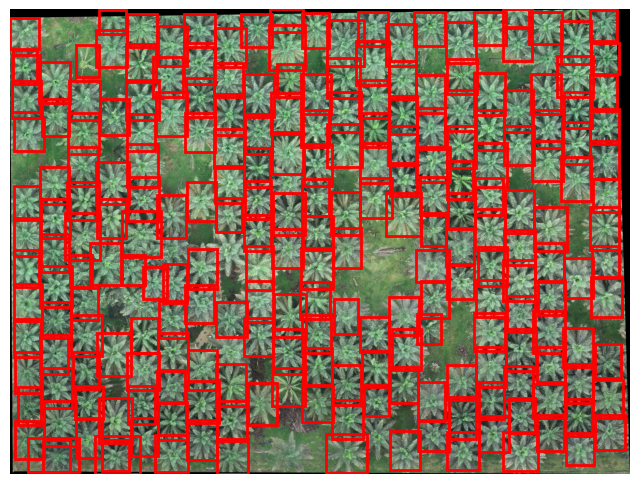

Jumlah objek terdeteksi: 229


In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms

# Fungsi untuk memvisualisasikan gambar dengan kotak prediksi
def plot_image_with_boxes(image, boxes, labels):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)

    ax = plt.gca()
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # Menghilangkan label angka, cukup menampilkan string kosong
        ax.text(xmin, ymin, '', fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# Menaikkan batas maksimal ukuran gambar untuk mencegah DecompressionBombError
Image.MAX_IMAGE_PIXELS = None

# Memuat gambar baru dan mengurangi resolusi jika terlalu besar
img_path = '/content/SAWIT P1.jpg'
image = Image.open(img_path).convert("RGB")

# Jika gambar terlalu besar, kurangi ukuran (misalnya 50%)
max_size = (5000, 5000)
if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
    image.thumbnail(max_size, Image.LANCZOS)  # Mengganti ANTIALIAS dengan LANCZOS

# Konversi gambar menjadi tensor
transform = transforms.ToTensor()
image_tensor = transform(image).unsqueeze(0).to(device)  # Mengubah menjadi tensor dan menambah dimensi batch

# Pastikan model sudah dimuat dan berada dalam mode eval
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model_instance_segmentation(2)  # Menggunakan 2 kelas (1 objek + background)
model.load_state_dict(torch.load('model_20.pt'))  # Memuat model yang sudah dilatih
model.to(device)
model.eval()

# Melakukan prediksi
with torch.no_grad():
    pred = model(image_tensor)

# Menentukan threshold untuk prediksi
threshold = 0.01
pred_boxes = []
pred_labels = []

# Menyaring prediksi berdasarkan skor
for idx in range(len(pred)):
    for i, score in enumerate(pred[idx]['scores']):
        if score > threshold:
            pred_boxes.append(pred[idx]['boxes'][i].cpu().numpy())
            pred_labels.append(pred[idx]['labels'][i].cpu().numpy())

# Menampilkan gambar asli dengan kotak prediksi
plot_image_with_boxes(image, pred_boxes, pred_labels)

# Menghitung jumlah box (bounding boxes)
num_boxes = len(pred_boxes)
print(f"Jumlah objek terdeteksi: {num_boxes}")

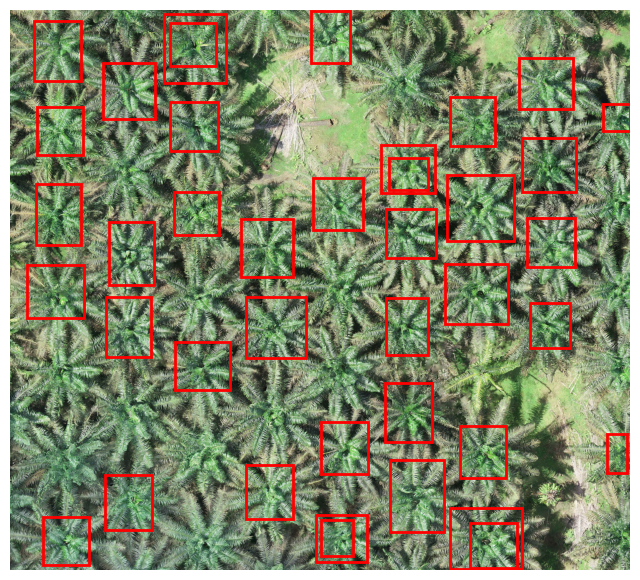

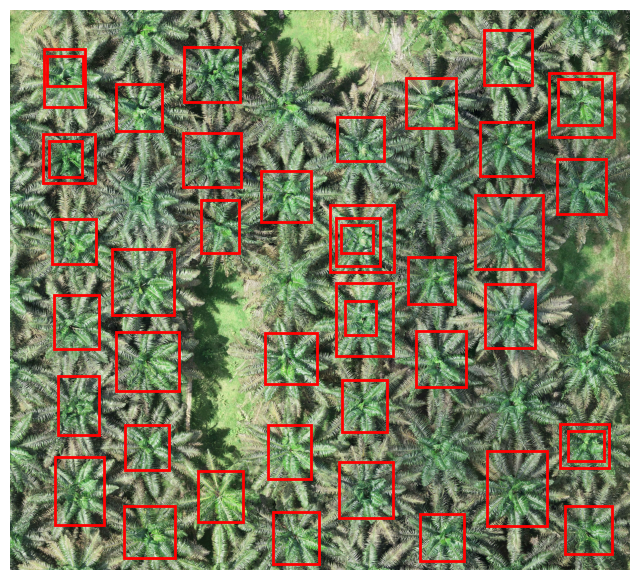

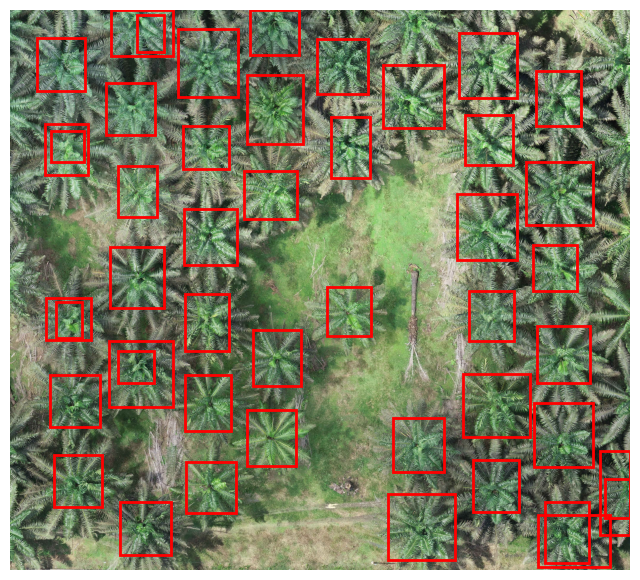

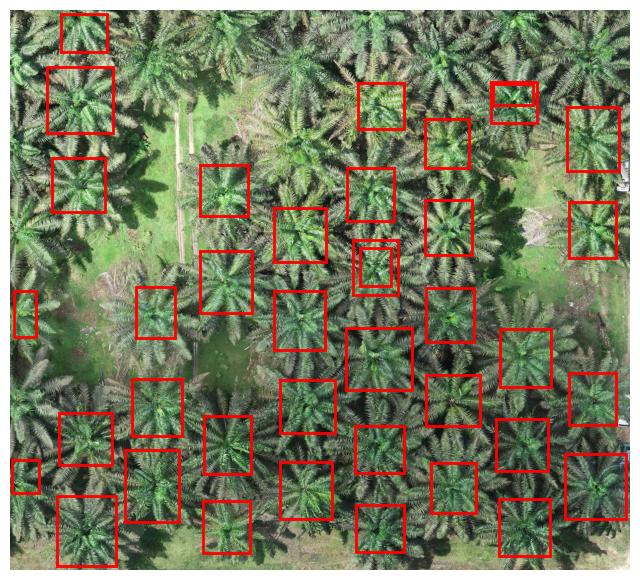

Jumlah label untuk setiap objek yang terdeteksi:
Label 1: 170 kali terdeteksi


In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms

# Fungsi untuk memvisualisasikan gambar dengan kotak prediksi
def plot_image_with_boxes(image, boxes, labels):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)

    ax = plt.gca()
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # Menghilangkan label angka, cukup menampilkan string kosong
        ax.text(xmin, ymin, '', fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# Menaikkan batas maksimal ukuran gambar untuk mencegah DecompressionBombError
Image.MAX_IMAGE_PIXELS = None

# Memuat gambar baru dan mengurangi resolusi jika terlalu besar
img_path = '/content/SAWIT P2 cmprs.jpg'
image = Image.open(img_path).convert("RGB")

# Jika gambar terlalu besar, kurangi ukuran (misalnya 50%)
max_size = (5000, 5000)
if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
    image.thumbnail(max_size, Image.LANCZOS)

# Konversi gambar menjadi tensor
transform = transforms.ToTensor()

# Mendapatkan ukuran gambar
width, height = image.size

# Membagi gambar menjadi 4 bagian
parts = [
    image.crop((0, 0, width // 2, height // 2)),  # Atas kiri
    image.crop((width // 2, 0, width, height // 2)),  # Atas kanan
    image.crop((0, height // 2, width // 2, height)),  # Bawah kiri
    image.crop((width // 2, height // 2, width, height))  # Bawah kanan
]

# Inisialisasi variabel untuk jumlah label
total_labels = {}

# Pastikan model sudah dimuat dan berada dalam mode eval
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model_instance_segmentation(2)  # Menggunakan 2 kelas (1 objek + background)
model.load_state_dict(torch.load('model_20.pt', weights_only=True))  # Memuat model yang sudah dilatih
model.to(device)
model.eval()

# Menentukan threshold untuk prediksi
threshold = 0.01

# Melakukan prediksi untuk setiap bagian
for idx, part in enumerate(parts):
    # Konversi bagian gambar menjadi tensor
    image_tensor = transform(part).unsqueeze(0).to(device)  # Mengubah menjadi tensor dan menambah dimensi batch

    # Melakukan prediksi
    with torch.no_grad():
        pred = model(image_tensor)

    # Menyaring prediksi berdasarkan skor
    pred_boxes = []
    pred_labels = []

    for i, score in enumerate(pred[0]['scores']):
        if score > threshold:
            pred_boxes.append(pred[0]['boxes'][i].cpu().numpy())
            label = pred[0]['labels'][i].cpu().numpy()
            pred_labels.append(label)

            # Menjumlahkan label (konversi label ke int)
            label_item = label.item()  # Mengambil nilai dari tensor NumPy
            if label_item in total_labels:
                total_labels[label_item] += 1
            else:
                total_labels[label_item] = 1

    # Menampilkan gambar bagian dengan kotak prediksi
    plot_image_with_boxes(part, pred_boxes, pred_labels)

# Menampilkan jumlah label untuk setiap objek
print("Jumlah label untuk setiap objek yang terdeteksi:")
for label, count in total_labels.items():
    print(f"Label {label}: {count} kali terdeteksi")
